In [1]:
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial

In [2]:
mol_str = """
H
H 1 0.74
symmetry c1
"""

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, }

# number of bondlengths in the scan
n = 100

# number of electronic states to save
N_el = 8

# array  for energies inside the cavity
cavity_E_array = np.zeros((n, N_el))


x_min = 0.5

x_max = 1

r_data = np.linspace(x_min, x_max, n)

In [3]:
mol_tmpl = """
H
H 1 **R**
symmetry c1
"""
options_dict = {
    "basis": "6-311G",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 2
}

psi4.set_options(options_dict)
fci_S0 = []
fci_S1 = []
r_idx = 0
for r in r_data:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))
    cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_E_array[r_idx,:] = cav.CIeigs[:N_el]
    r_idx += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Fri Jan 19 13:39:39 2024

   => Loading Basis Set <=

    Name: 6-311G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    21 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/6-311g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charg

Min on S0 is 0.7474747474747475
        5         4         3         2
-3.792 x + 16.83 x - 30.51 x + 28.43 x - 13.56 x + 1.472
529.2154427270184


<function matplotlib.pyplot.show(close=None, block=None)>

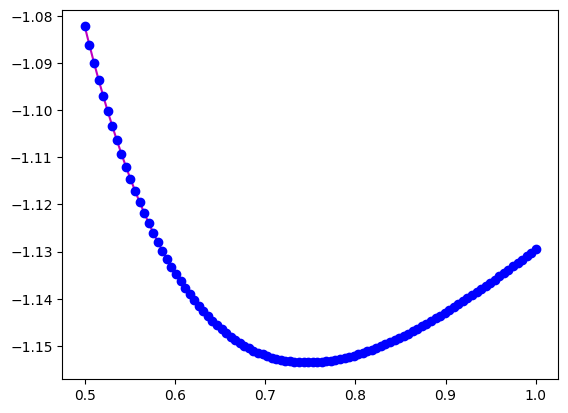

In [4]:
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
min_S0_loc = np.argmin(fci_S0[:])
r_eq_ang = r_data[min_S0_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')

# Fitting S0 PES to a quintic polynomial
poly = np.poly1d(np.polyfit(r_data, fci_S0, 5))
print(poly)

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, fci_S0[:], 'bo', label='cavity free |g>')
plt.show

In [71]:
r_eq_SI = r_eq_ang * 10 ** (-10)
r_eq_au = r_eq_ang * 1.88973
r_data_SI = r_data * 10 ** (-10)
r_data_au = r_data * 1.88973
delta_x_ang = x_max - x_min / n 
delta_x_au = delta_x_ang * 1.88973
length_m = (n - 1) * delta_x_ang * 10 ** (-10)
length_au = (n - 1) * delta_x_au
mu = 1 #(1.007 * 1.007 / (1.007 + 1.007)) / (1000 * 6.022 * 10 ** 23)
h = 6.626 * 10 ** (-34)
hbar = 1 #scipy.constants.hbar
D_e_kJ_mol = 435.780 
D_e_J = D_e_kJ_mol * 1000 / (6.022* 10 ** 23)
D_e_H = D_e_J * 2.294 * 10 ** 17
a = np.sqrt(k_test_SI / (2 * D_e_J))
r_recip = 1 / r_data_au
T_ij = np.zeros((n, n))
V_ij = np.zeros((n, n))
H_ij = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        for l in range(n):
            #T_l = (2 / mu) * (hbar * l / (2 * length)) ** 2
            T_ij[i,j] = np.cos(2 * np.pi * r_data_au[l] * (r_data_au[i] - r_data_au[j] / (n - 1))) * (2 / mu) * (hbar * r_data_au[l] / (2 * length_au)) ** 2
            V_ij[i,j] = 0.5 * (r_data_au[i] - r_eq_au) ** 2 * i==j
            #V_ij[i,j] = D_e_H * (1 - np.exp(-a * (r_data_SI[i] - r_eq_SI))) ** 2 * i==j
            H_ij = T_ij + V_ij
print(H_ij)

H_diag = np.linalg.eigh(H_ij)
eigenvalues = H_diag.eigenvalues
eigenvectors = H_diag.eigenvectors
#print(f'the eigenvales are {eigenvalues}')
print(f'the eigenvectors are {eigenvectors}')

[[ 1.00000566e+00  5.59717218e-06  5.53853376e-06  5.47988809e-06
   5.42123523e-06  5.36257527e-06  5.30390829e-06  5.24523435e-06
   5.18655355e-06  5.12786594e-06  5.06917162e-06  5.01047066e-06
   4.95176313e-06  4.89304911e-06  4.83432868e-06  4.77560192e-06
   4.71686890e-06  4.65812970e-06  4.59938440e-06  4.54063307e-06
   4.48187579e-06  4.42311264e-06  4.36434369e-06  4.30556902e-06
   4.24678872e-06  4.18800285e-06  4.12921149e-06  4.07041472e-06
   4.01161262e-06  3.95280526e-06  3.89399272e-06  3.83517508e-06
   3.77635242e-06  3.71752480e-06  3.65869232e-06  3.59985504e-06
   3.54101305e-06  3.48216641e-06  3.42331521e-06  3.36445953e-06
   3.30559944e-06  3.24673502e-06  3.18786634e-06  3.12899349e-06
   3.07011654e-06  3.01123556e-06  2.95235064e-06  2.89346185e-06
   2.83456927e-06  2.77567298e-06  2.71677305e-06  2.65786956e-06
   2.59896258e-06  2.54005221e-06  2.48113850e-06  2.42222154e-06
   2.36330141e-06  2.30437818e-06  2.24545193e-06  2.18652274e-06
   2.12759

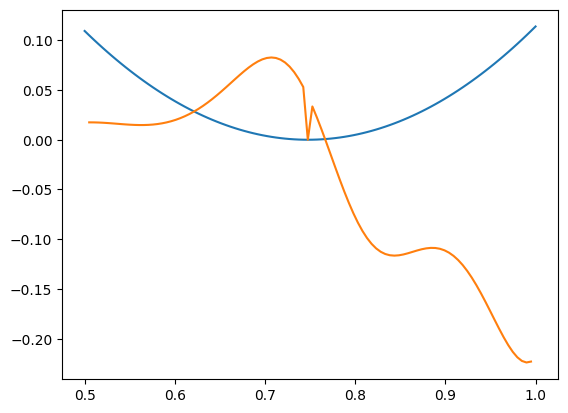

In [75]:
V_x = np.zeros((1,n))
for i in range(n):
    V_x[0,i] = 0.5 * (r_data_au[i] - r_eq_au) ** 2

eig_0 = np.zeros((1,n))
for i in range(n):
    eig_0[0,i] = eigenvalues[0]

plt.plot(r_data, V_x[0,:])
#plt.plot(r_data_au, eigenvalues)
plt.plot(r_data[1:99], eigenvectors[1:99,2])
#plt.xlim(0.74,0.76)
#plt.ylim(-0.001,0.001)